# DL model InceptionV3.

 This script is was used for the different tests with the DL model InceptionV3 which are described in the report. There are several options:
* Using masks and not using masks.
* Use fine-tuning of the base model or not

These options can be addressed by setting flags in the head of the script or by commenting and uncommenting several parts.

## imports

In [1]:
import os
import zipfile
import shutil
from pathlib import Path
import random
import glob
import pandas as pd
import numpy as np

import tensorflow as tf
import albumentations as A
import cv2
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns


from tensorflow import keras, TensorSpec
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
#from tensorflow.keras.applications import VGG16
#from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.data import Dataset, experimental


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## definitions to set by user

In [2]:
# set "machine" according to where you want to run the script
machine = 'colab' # 'colab' or 'local'

# modelname:
model_name = 'inceptionv3_13'

# size to which the X-ray images have to be converted to (according to the model which is used):
IMG_HEIGHT, IMG_WIDTH = 299, 299

# batch size used for modelling:
BATCH_SIZE = 64

# Flags that control whether the masks are applied to the train data / validation / test data (= True) or not (=False)
flag_masks_train      = True
flag_masks_validation = True
flag_masks_test       = True

##############################################################################################
# number of classes which should be predicted:
NUM_CLASSES = 4

# names of the classes and dicts to address the names by ID of the class and vice versa:
classes = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
class_to_index = {cls: idx for idx, cls in enumerate(classes)}
index_to_class =  {v: k for k, v in class_to_index.items()} # Invert the dictionary

# random number in order to reproduce the split etc.
rand_num = 42

## load directories on colab

In [3]:
if machine == 'colab':
    #from google.colab import files
    #files.upload()

    # load google drive when working on colab
    from google.colab import drive
    #drive.mount('/content/drive')
    drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## definitions of paths

In [4]:
#####################################
# paths:
#####################################

if machine == 'local':
    # paths to load data:
    base_path = r"..\\data\\"
    base_path_zip = os.path.join(base_path, "raw")                       # path where zip-file is
    base_path_raw = base_path_zip                                        # path where raw data is unziped to  (on local machine same as path where zip is)
    base_path_processed = os.path.join(base_path, "processed", "DL")     # path where processed data is saved

    # paths to save models:
    model_path = r"..\\Models\\local\\DL"

elif machine == 'colab':
    # paths to load data:
    base_path_drive     = '/content/drive/MyDrive/data'         # base path on DRIVE
    base_path_colab     =  '/content/data'                      # base path on COLAB
    base_path_zip       = os.path.join(base_path_drive, 'raw')  # path where zip-file is (on drive)
    base_path_raw       = os.path.join(base_path_colab, 'raw')  # path where raw data is unziped to (on colab machine not on drive)
    base_path_processed = os.path.join(base_path_colab, 'processed')  # path where processed data is saved (on colab machine not on drive)


    # paths to save models:
    model_path = '/content/drive/MyDrive/models/DL'

## unzip

In [5]:
archive_zip = 'covid19-radiography-database.zip'
unzipped_folder = 'COVID-19_Radiography_Dataset'

if machine == 'local':

    # only unzip if target folder not already exists:
    if not os.path.exists(os.path.join(base_path_raw,unzipped_folder)):
        with zipfile.ZipFile(os.path.join(base_path_zip, archive_zip), 'r') as zip_ref:
            for file_name in zip_ref.namelist():
                zip_ref.extract(file_name, base_path_raw)  # Extract files into target folder
            print("zip-archive {} unziped to folder: {}." .format(archive_zip, os.path.join(base_path_raw,unzipped_folder)))
    else:
        print('Nothing to unzip, folder already exist.')

elif machine == 'colab':
    # create directory
    os.makedirs(base_path_raw, exist_ok=True)
    os.makedirs(base_path_processed, exist_ok=True)

    # only unzip if target folder not already exists:
    if not os.path.exists(os.path.join(base_path_raw,unzipped_folder)):
        with zipfile.ZipFile(os.path.join(base_path_zip, archive_zip), 'r') as zip_ref:
            for file_name in zip_ref.namelist():
                zip_ref.extract(file_name, base_path_raw)  # Extract files into target folder
            print("zip-archive {} unziped to folder: {}." .format(archive_zip, os.path.join(base_path_raw,unzipped_folder)))
    else:
        print('Nothing to unzip, folder already exist.')


zip-archive covid19-radiography-database.zip unziped to folder: /content/data/raw/COVID-19_Radiography_Dataset.


## Train - test split

In [6]:
random.seed(rand_num)

# Set paths for source (downloaded data) and destination (processed train/test)
source_dir = os.path.join(base_path_raw, unzipped_folder)
dest_dir = base_path_processed

train_dir = os.path.join(dest_dir, "train_data")
test_dir = os.path.join(dest_dir, "test_data")

split_ratio = 0.85

for cls in classes:
    print(f"Processing class: {cls}")

    # Paths to images and masks in raw data
    images_path = os.path.join(source_dir, cls, "images")
    masks_path = os.path.join(source_dir, cls, "masks")

    # List image files only
    all_images = [img for img in os.listdir(images_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(all_images)

    split_index = int(len(all_images) * split_ratio)
    train_imgs = all_images[:split_index]
    test_imgs = all_images[split_index:]

    # Create destination directories
    train_img_dir = os.path.join(train_dir, cls, "images")
    train_mask_dir = os.path.join(train_dir, cls, "masks")
    test_img_dir = os.path.join(test_dir, cls, "images")
    test_mask_dir = os.path.join(test_dir, cls, "masks")

    os.makedirs(train_img_dir, exist_ok=True)
    os.makedirs(train_img_dir, exist_ok=True)
    os.makedirs(train_mask_dir, exist_ok=True)
    os.makedirs(test_img_dir, exist_ok=True)
    os.makedirs(test_mask_dir, exist_ok=True)

    # Copy images and corresponding masks
    for img in train_imgs:
        shutil.copy(os.path.join(images_path, img), os.path.join(train_img_dir, img))
        mask_file = os.path.join(masks_path, img)
        if os.path.exists(mask_file):
            shutil.copy(os.path.join(mask_file), os.path.join(train_mask_dir, img))

    for img in test_imgs:
        shutil.copy(os.path.join(images_path, img), os.path.join(test_img_dir, img))
        mask_file = os.path.join(masks_path, img)
        if os.path.exists(mask_file):
            shutil.copy(mask_file, os.path.join(test_mask_dir, img))

    print(f"  Copied {len(train_imgs)} images (and masks if available) to {train_img_dir}")
    print(f"  Copied {len(test_imgs)} images (and masks if available) to {test_img_dir}")


Processing class: Normal
  Copied 8663 images (and masks if available) to /content/data/processed/train_data/Normal/images
  Copied 1529 images (and masks if available) to /content/data/processed/test_data/Normal/images
Processing class: COVID
  Copied 3073 images (and masks if available) to /content/data/processed/train_data/COVID/images
  Copied 543 images (and masks if available) to /content/data/processed/test_data/COVID/images
Processing class: Lung_Opacity
  Copied 5110 images (and masks if available) to /content/data/processed/train_data/Lung_Opacity/images
  Copied 902 images (and masks if available) to /content/data/processed/test_data/Lung_Opacity/images
Processing class: Viral Pneumonia
  Copied 1143 images (and masks if available) to /content/data/processed/train_data/Viral Pneumonia/images
  Copied 202 images (and masks if available) to /content/data/processed/test_data/Viral Pneumonia/images


## resplit the train set into train (80%) and validation (20%) set

In [7]:
data_dir = train_dir

all_img_paths = []
all_class_indices = []

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name, "images")
    img_files = glob.glob(f"{class_dir}/*.png")
    for img_file in img_files:
        all_img_paths.append(str(img_file))
        all_class_indices.append(class_to_index[class_name])

# Train/val split
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    all_img_paths, all_class_indices, test_size=0.2, stratify=all_class_indices, random_state=rand_num
)

In [8]:
# create list with test-data images which contains path and filename (same structure as train and validation)

test_imgs_with_path = []

for class_name in classes:
    class_dir = os.path.join(test_dir, class_name, "images")
    img_files = glob.glob(f"{class_dir}/*.png")
    for img_file in img_files:
        test_imgs_with_path.append(str(img_file))

test_imgs = test_imgs_with_path

## optional apply masks

In [14]:
print("First elements of train_imgs:")
print(train_imgs[:2])
print("First elements of val_imgs:")
print(val_imgs[:2])
print("First elements of test_imgs:")
print(test_imgs[:2])

First elements of train_imgs:
['/content/data/processed/train_data_with_masks/Lung_Opacity/images/Lung_Opacity-4354.png', '/content/data/processed/train_data_with_masks/Normal/images/Normal-5606.png']
First elements of val_imgs:
['/content/data/processed/train_data_with_masks/Normal/images/Normal-834.png', '/content/data/processed/train_data_with_masks/Normal/images/Normal-4155.png']
First elements of test_imgs:
['/content/data/processed/test_data/Normal/images/Normal-6679.png', '/content/data/processed/test_data/Normal/images/Normal-1345.png']


In [ ]:
def apply_mask(list_images, list_labels):
    """
    apply_mask applies the corresponding masks to the images for a given dataset

    :list_images: list of images of a data set, e.g. the train dataset
    :list_labels: list of labels of a data set, e.g. the train dataset

    :return: set_imgs_with_masks, set_label_with_masks (two lists of the images with masks and the corresponding labels)
    """
    set_imgs_with_masks = []      # create empty list for the images to which the mask has been applied
    set_label_with_masks = []     # create empty list for labels of images to which the mask has been applied

    # loop through all images of the given dataset:
    for label, set_item in zip(list_labels, list_images):
        image_dir      = os.path.split(set_item)[0]            # get dir of image
        filename = os.path.split(set_item)[1]                  # get filename of iamge
        mask_dir       = image_dir.replace('images', 'masks')  # create string with dir where masks are located

        # create path to image and corresponding mask:
        image_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)

        # Load image and mask
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            print(f"Skipping {filename}: missing image or mask")
            continue

        # iamges with applied masks should be saved to another dir "..\train_data_with_masks\.."
        # Therefore the string in the original list e.g. train_imgs is changed.
        # The new dir is created if it does not exist already.
        set_imgs_with_masks_dir = image_dir.replace('train_data', 'train_data_with_masks')    # this is ok for validation AND train, as there is no extra folder for the validation data. The train data is resplit but only in memory, not written to disk
        os.makedirs(set_imgs_with_masks_dir, exist_ok=True)

        # Resize mask to match image size
        mask_resized = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))

        # Ensure binary mask (0, 255)
        _, mask_binary = cv2.threshold(mask_resized, 127, 255, cv2.THRESH_BINARY)

        # Keep iamge pixels inside lung mask, zero elsewhere
        processed_img = cv2.bitwise_and(img, img, mask=mask_binary)

        # save image with applied mask:
        save_path = os.path.join(set_imgs_with_masks_dir, filename)
        cv2.imwrite(save_path, processed_img)

        # append path to new image with applied masks to list set_imgs_with_masks:
        set_imgs_with_masks.append(save_path)
        set_label_with_masks.append(label)

    return set_imgs_with_masks, set_label_with_masks


def apply_mask_test(list_images):
    """
    apply_mask_test applies the corresponding masks to the images for a test dataset.
    An extra function is needed, because the test-dataset does not have a
    corresponding label list yet.

    :list_images: list of images of a data set, e.g. the train dataset
    :list_labels: list of labels of a data set, e.g. the train dataset

    :return: set_imgs_with_masks, set_label_with_masks (two lists of the images with masks and the corresponding labels)
    """
    set_imgs_with_masks = []      # create empty list for the images to which the mask has been applied

    # loop through all images of the given dataset:
    for set_item in list_images:
        image_dir      = os.path.split(set_item)[0]            # get dir of image
        filename = os.path.split(set_item)[1]                  # get filename of iamge
        mask_dir       = image_dir.replace('images', 'masks')  # create string with dir where masks are located

        # create path to image and corresponding mask:
        image_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)

        # Load image and mask
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            print(f"Skipping {filename}: missing image or mask")
            continue

        # iamges with applied masks should be saved to another dir "..\train_data_with_masks\.."
        # Therefore the string in the original list e.g. train_imgs is changed.
        # The new dir is created if it does not exist already.
        set_imgs_with_masks_dir = image_dir.replace('test_data', 'test_data_with_masks')
        os.makedirs(set_imgs_with_masks_dir, exist_ok=True)

        # Resize mask to match image size
        mask_resized = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))

        # Ensure binary mask (0, 255)
        _, mask_binary = cv2.threshold(mask_resized, 127, 255, cv2.THRESH_BINARY)

        # Keep iamge pixels inside lung mask, zero elsewhere
        processed_img = cv2.bitwise_and(img, img, mask=mask_binary)

        # save image with applied mask:
        save_path = os.path.join(set_imgs_with_masks_dir, filename)
        cv2.imwrite(save_path, processed_img)

        # append path to new image with applied masks to list set_imgs_with_masks:
        set_imgs_with_masks.append(save_path)

    return set_imgs_with_masks

optionally apply masks to X-ray images if corresponding flag is activated:
if flag_masks_train == True:
    train_imgs, train_labels = apply_mask(train_imgs, train_labels)
    print("Train-dataset: Masks have been applied to the X-ray images.")

if flag_masks_validation == True:
    val_imgs, val_labels = apply_mask(val_imgs, val_labels)
    print("Validation-dataset: Masks have been applied to the X-ray images.")

if flag_masks_test == True:
    test_imgs = apply_mask_test(test_imgs)
    test_dir = test_dir.replace('test_data', 'test_data_with_masks')   # change directory where the test-images will be taken from
    print("Test-dataset: Masks have been applied to the X-ray images.")



Test-dataset: Masks have been applied to the X-ray images.


In [20]:
print(flag_masks_train, flag_masks_validation, flag_masks_test)

print("First elements of train_imgs:")
print(train_imgs[:2])
print("First elements of val_imgs:")
print(val_imgs[:2])
print("First elements of test_imgs:")
print(test_imgs[:2])

True True True
First elements of train_imgs:
['/content/data/processed/train_data_with_masks/Lung_Opacity/images/Lung_Opacity-4354.png', '/content/data/processed/train_data_with_masks/Normal/images/Normal-5606.png']
First elements of val_imgs:
['/content/data/processed/train_data_with_masks/Normal/images/Normal-834.png', '/content/data/processed/train_data_with_masks/Normal/images/Normal-4155.png']
First elements of test_imgs:
['/content/data/processed/test_data_with_masks/Normal/images/Normal-6679.png', '/content/data/processed/test_data_with_masks/Normal/images/Normal-1345.png']


## data augmentation for the train set - to fix the class imbalance

In [21]:
# Define augmentation pipeline

# define probabilities of applying the different augmentation methods
prob_rotate = 0.5    # probaility of using rotation
prob_shift = 0.5     # probaility of using shifting
prob_pipeline = 1.0  # The entire pipeline has a 100% chance to be applied. We want every image to be changed


# Define the augmentation pipeline
augmentation_pipeline_CI = A.Compose([
    A.OneOf([
        A.Rotate(limit=15, p=prob_rotate),                                                 # Rotate with a limit of ±15 degrees
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=0, p=prob_shift)  # Translation (shifting)
    ], p=prob_pipeline)

], p=1.0,                    # probability of the entire pipeline to be applied
seed = rand_num,                  # added seed for reproducibility
save_applied_params=True)    # save applied transformation parameters

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [22]:
# assume that the normal class (label = 0) is the majority class and only the other classes have to be augmented:
# class_aug = [1,2,3]
class_aug = [0,1,2,3]

# determine number of images for normal class (label = 0) in train data set:
counts = pd.Series(train_labels).value_counts()
# max_num = counts[0]
max_num = 2*counts[0]

iteration_per_class = {}

for class_label in [0,1,2,3]:
    class_num = counts[class_label]

    div_res = round(max_num/class_num,0)    # calculate how many augmentation iteration we need
    iteration = div_res - 1                 # it needs one iteration less, because we add the unaugmented data

    iteration_per_class.update({class_label: iteration})

In [23]:
iteration_per_class

{0: np.float64(1.0),
 1: np.float64(5.0),
 2: np.float64(2.0),
 3: np.float64(14.0)}

In [24]:
train_imgs_aug = []
train_labels_aug = []

# loop through items of list with training images and corresponding labels
for label, img_path in zip(train_labels, train_imgs):
    # only do augmentation if class is not 'Normal'
    if label in class_aug:

        # define output path for augmented image
        augmented_dir = os.path.split(img_path)[0]


        # how many iterations of augmentation do we need?
        num_iter = iteration_per_class[label]


        iter = 1
        # for each file in the data frame to as many augmentation, as needed for this class

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            while iter <= num_iter:

                augmented = augmentation_pipeline_CI(image=img)
                augmented_img = augmented['image']

                # save used transformation to dict
                #used_transformation.update({img_name:augmented['applied_transforms']})

                # define name for augmented image
                split_name, split_ending = os.path.split(img_path)[1].split('.')
                img_name_aug = split_name + "_ag" + str(iter) + "." + split_ending

                # save augmented image
                save_path = os.path.join(augmented_dir, img_name_aug)
                cv2.imwrite(save_path, augmented_img)

                # append path to new augmented image to list train_imgs_aug:
                train_imgs_aug.append(save_path)
                train_labels_aug.append(label)

                iter +=1

# append augmented img and labels to lists for train data:
train_imgs.extend(train_imgs_aug)
train_labels.extend(train_labels_aug)

In [16]:
# check number of images per class
counts = pd.Series(train_labels).value_counts()
print('number of images per class after augmentation:')
print(counts)

number of images per class after augmentation:
1    14748
0    13860
3    13725
2    12264
Name: count, dtype: int64


## create tensors: train (with augmentation), validation

In [25]:
# Albumentations augmentation pipeline to randomly augment images from ALL classes
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=0, p=0.5),
])

# ----------- Data Generator -----------

def load_classification_image(img_path, label, augment_data=False):
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

    if augment_data:
        img = augment(image=img)['image']

#    img = img.astype(np.float32) / 255.0
    img = img.astype(np.float32)
    img = np.stack([img]*3, axis=-1)  # convert grayscale to RGB
    return img, label

def classification_generator(img_paths, labels, augment_data=False):
    for img_path, label in zip(img_paths, labels):
        img, lbl = load_classification_image(img_path, label, augment_data=augment_data)
        yield img, lbl

def create_classification_dataset(img_paths, labels, batch_size, augment=False):
    dataset = tf.data.Dataset.from_generator(
        lambda: classification_generator(img_paths, labels, augment_data=augment),
        output_signature=(
            tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
    if augment:
        dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = create_classification_dataset(train_imgs, train_labels, batch_size=BATCH_SIZE, augment=True)
val_ds = create_classification_dataset(val_imgs, val_labels, batch_size=BATCH_SIZE, augment=False)

print(f"Train batches: {len(list(train_ds))}")
print(f"Validation batches: {len(list(val_ds))}")

KeyboardInterrupt: 

## create tensors: test

In [18]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
from pathlib import Path

TEST_DATA_DIR = test_dir

X_test_raw = []
y_test_raw = []

for cls_index, cls_name in enumerate(classes):
    img_dir = os.path.join(TEST_DATA_DIR, cls_name, "images")
    img_files = glob.glob(f"{img_dir}/*.png")

    for img_file in img_files:
        img = load_img(img_file, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
        # img_array = img_to_array(img).astype(np.float32) / 255.0
        img_array = img_to_array(img).astype(np.float32)
        img_array = np.repeat(img_array, repeats=3, axis=-1)  # Convert grayscale to RGB

        X_test_raw.append(img_array)
        y_test_raw.append(cls_index)  # Image-level class label

# Convert to NumPy arrays
X_test = np.array(X_test_raw, dtype=np.float32)
y_test = np.array(y_test_raw, dtype=np.int32)

print("X_test shape:", X_test.shape)  # (N, img_height, img_width, 3)
print("y_test shape:", y_test.shape)  # (N,)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


X_test shape: (3176, 299, 299, 3)
y_test shape: (3176,)


In [19]:
# train_ds = train_dataset
# test_ds = test_dataset
# val_ds = val_dataset

In [20]:
# apply preprocessing of model

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

## display some images

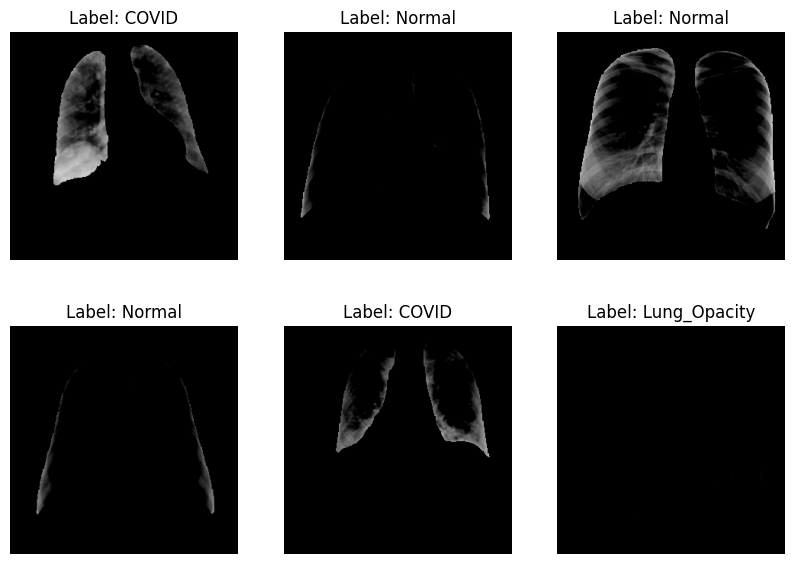

In [21]:
# Define the number of images to display
number_of_images = 6

# Create a figure for displaying
plt.figure(figsize=(10,7))

# Get a batch of images from train_ds
for batch, labels in train_ds.take(1):
    # Display the images from the batch
    for i in range(number_of_images):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(batch[i].numpy())  # Convert the image to integer for display
        plt.axis("off")
        plt.title(f"Label: {index_to_class[labels[i].numpy()]}")

# Show the images
plt.show()

# Modelling

## define the model

In [22]:
# Load InceptionV3 base without top
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
#base_model.trainable = False  # Freeze InceptionV3 layers

# # Unfreeze last 4 convolutional layers
# for layer in base_model.layers[:-4]:
#     layer.trainable = False
# for layer in base_model.layers[-4:]:
#     layer.trainable = True

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in base_model.layers[:249]:
   layer.trainable = False
for layer in base_model.layers[249:]:
   layer.trainable = True

# Input
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
# x = preprocess_input(inputs)  # has alreaday been done to train, test and validation before during preprocessing
#x = base_model(inputs, training=False)  # Pass input through InceptionV3
x = base_model(inputs)  # Pass input through InceptionV3

# # Classification head
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# x = Dropout(0.2)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.2)(x)
# outputs = Dense(5, activation='softmax')(x)  # 5 classes (adjust if needed)

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(256, activation="relu")(x)  # Extra learning capacity
x = Dense(128, activation="relu")(x)  # Fine-tuning details
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

## Compile the model



In [24]:
# Build and compile model
model = Model(inputs=inputs, outputs=outputs)
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy']) # adam optimizer
#model.compile(optimizer=RMSprop(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy']) # RMSprop optimizer
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,590,500 (93.81 MB)

 Trainable params: 13,902,596 (53.03 MB)

 Non-trainable params: 10,687,904 (40.77 MB)

In [25]:
# create sub-folder for images of model results:
# new sub-folder is located here: \models\local\DL\results\'model_name'\
model_results_path = os.path.join(model_path, 'results', model_name)
os.makedirs(model_results_path, exist_ok=True)


# save model stucture as png
from tensorflow.keras.utils import plot_model

save_path = os.path.join(model_results_path, model_name + '_model_design.png')
plot_model(model, to_file=save_path, show_shapes=True, show_layer_names=True)
print(f"Model plot saved to: {save_path}")

Model plot saved to: /content/drive/MyDrive/models/DL/results/inceptionv3_12/inceptionv3_12_model_design.png


In [26]:
# ## define steps per epoche:
# steps_per_epoch = len(train_imgs) // BATCH_SIZE  # Total samples / batch size
# validation_steps = len(val_imgs) // BATCH_SIZE


# --- Callbacks ---


# my callbacks
# early_stopping = EarlyStopping(
#     monitor = 'val_loss',
#     min_delta = 0.01,   # If the loss function doesn't change by 1% after 5 epochs, either up or down, we stop
#     patience = 5,       # Wait for 5 epochs before applying
#     verbose = 1,        # to display the epoch at which training stops
#     mode = 'min',
#     restore_best_weights=True
# )

# reduce_learning_rate = ReduceLROnPlateau(
#     monitor = 'val_loss',
#     min_delta = 0.01,
#     patience = 3,         # If val_loss stagnates for 3 consecutive epochs based on the min_delta value
#     factor = 0.1,         # Reduce the learning rate by a factor of 0.1
#     cooldown = 4,         # Wait 4 epochs before retrying
#     verbose = 1
# )

# save = ModelCheckpoint(os.path.join(model_path, model_name + '_best_saved_during_training' + ".keras"),
#                                 save_best_only=True,
#                                 monitor='val_accuracy',
#                                 mode='min')


# Saniyas callbacks:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
save = ModelCheckpoint(os.path.join(model_path, model_name + '_best_saved_during_training' + ".keras"), save_best_only=True, monitor='val_loss')


EPOCHS = 20
steps_per_epoch = len(train_imgs) // BATCH_SIZE
validation_steps = len(val_imgs) // BATCH_SIZE


# --- Train model ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    #callbacks=[early_stopping, save]
    callbacks=[save, reduce_learning_rate, early_stopping]
)



# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=EPOCHS,
#     steps_per_epoch=steps_per_epoch,
#     validation_steps=validation_steps,
# )

Epoch 1/20
853/853 ━━━━━━━━━━━━━━━━━━━━ 185s 175ms/step - accuracy: 0.4797 - loss: 1.2114 - val_accuracy: 0.6819 - val_loss: 0.8429 - learning_rate: 1.0000e-04
Epoch 2/20
  1/853 ━━━━━━━━━━━━━━━━━━━━ 3:32:15 15s/step - accuracy: 0.4000 - loss: 0.8711

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


853/853 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.4000 - loss: 0.8711 - val_accuracy: 0.6819 - val_loss: 0.8415 - learning_rate: 1.0000e-04
Epoch 3/20
853/853 ━━━━━━━━━━━━━━━━━━━━ 143s 168ms/step - accuracy: 0.7118 - loss: 0.7415 - val_accuracy: 0.7400 - val_loss: 0.6395 - learning_rate: 1.0000e-04
Epoch 4/20
853/853 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4000 - loss: 1.6437 - val_accuracy: 0.7422 - val_loss: 0.6379 - learning_rate: 1.0000e-04
Epoch 5/20
853/853 ━━━━━━━━━━━━━━━━━━━━ 142s 166ms/step - accuracy: 0.7639 - loss: 0.5992 - val_accuracy: 0.7751 - val_loss: 0.5594 - learning_rate: 1.0000e-04
Epoch 6/20
853/853 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4000 - loss: 2.4256 - val_accuracy: 0.7765 - val_loss: 0.5590 - learning_rate: 1.0000e-04
Epoch 7/20
853/853 ━━━━━━━━━━━━━━━━━━━━ 143s 168ms/step - accuracy: 0.7949 - loss: 0.5288 - val_accuracy: 0.8047 - val_loss: 0.4968 - learning_rate: 1.0000e-04
Epoch 8/20
853/853 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy

## Evaluation

In [27]:
results = model.evaluate(test_ds)
print(f"Test Loss: {results[0]:.4f} - Test Accuracy: {results[1]:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 301ms/step - accuracy: 0.1012 - loss: 4.3035
Test Loss: 3.7360 - Test Accuracy: 0.1722


In [28]:
# Save in the Keras format (recommended in TF 2.x)
model.save(os.path.join(model_path, model_name + ".keras"))

In [29]:
history.history

{'accuracy': [0.5775021910667419,
  0.4000000059604645,
  0.7432224750518799,
  0.4000000059604645,
  0.7836862802505493,
  0.4000000059604645,
  0.8090928792953491,
  0.800000011920929,
  0.8257620334625244,
  0.800000011920929,
  0.8416251540184021,
  0.800000011920929,
  0.8511137366294861,
  0.6000000238418579,
  0.860144317150116,
  1.0,
  0.8677461743354797,
  1.0,
  0.8727835416793823,
  0.800000011920929],
 'loss': [1.0785117149353027,
  0.8711063265800476,
  0.6634078025817871,
  1.6436948776245117,
  0.5508116483688354,
  2.4255881309509277,
  0.49006712436676025,
  0.8349501490592957,
  0.4479881227016449,
  0.966881275177002,
  0.41533687710762024,
  0.22371479868888855,
  0.393422394990921,
  0.41379499435424805,
  0.3689173460006714,
  0.19994531571865082,
  0.35143738985061646,
  0.10618028789758682,
  0.3365015983581543,
  0.7178700566291809],
 'val_accuracy': [0.6819196343421936,
  0.6819196343421936,
  0.7399553656578064,
  0.7421875,
  0.7751116156578064,
  0.7765067

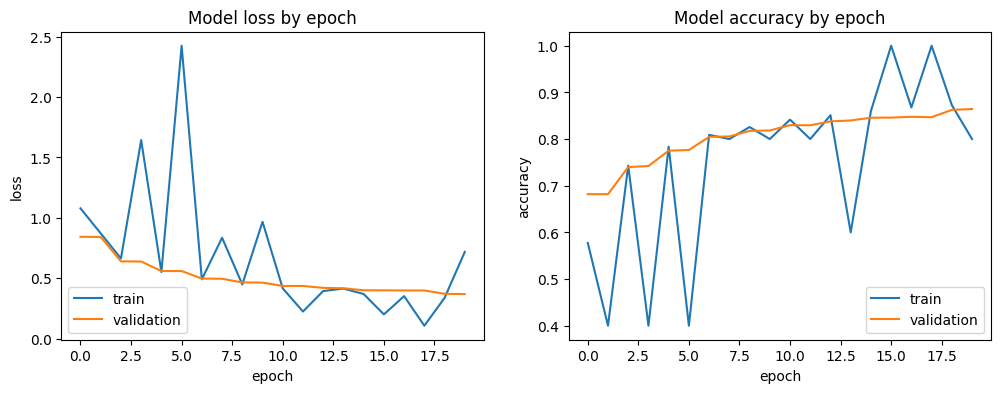

In [30]:
loss_accuracy_file = os.path.join(model_results_path, model_name + '_loss_accuracy.png')

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig(loss_accuracy_file, format='png')
plt.show()



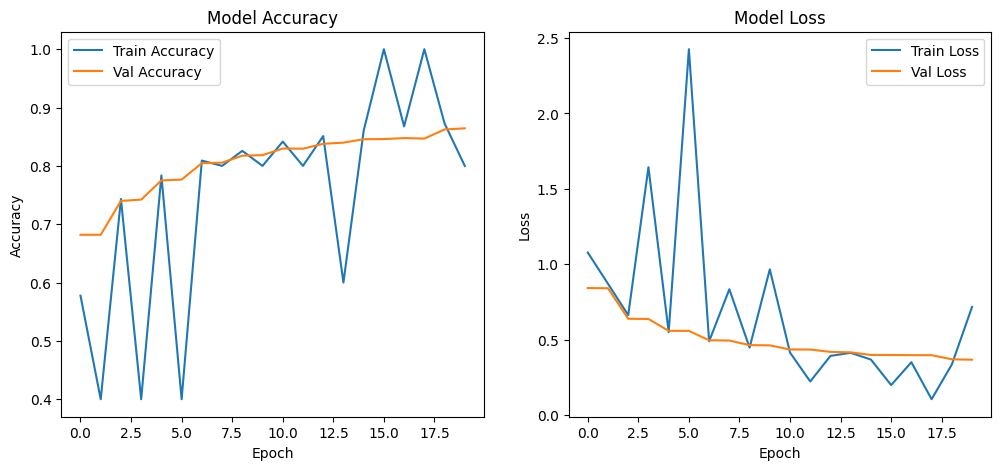

In [31]:
# Plot training & validation accuracy values
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [32]:
# Predict probabilities
y_pred_probs = model.predict(test_ds)

# Convert probs to class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # shape: (num_samples,)

y_true = y_test

50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 181ms/step


### classification report (screenshot for report)

In [33]:
# Display the classification report
print(classification_report(y_true, y_pred, target_names=classes))  # Print the classification report (precision, recall, F1-score)



                 precision    recall  f1-score   support

         Normal       0.00      0.00      0.00      1529
          COVID       0.17      1.00      0.29       543
   Lung_Opacity       0.00      0.00      0.00       902
Viral Pneumonia       0.56      0.02      0.05       202

       accuracy                           0.17      3176
      macro avg       0.18      0.26      0.08      3176
   weighted avg       0.06      0.17      0.05      3176



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### confusion matrix

In [34]:
def create_cm(y_test, y_pred, flag_norm, model_path, model_name):
    # create and save confusion matrix

    if not (flag_norm is None):
        print("norma")
        print(flag_norm)
        cm_file     = os.path.join(model_path, model_name + "_cm_norm.png")
        format_anot = '.2f'
    else:
        print("abs")
        print(flag_norm)
        cm_file     = os.path.join(model_path, model_name + "_cm_abs.png")
        format_anot = 'd'

    cm = confusion_matrix(y_test, y_pred, normalize=flag_norm)

    #list_labels_enc = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

    plt.figure(figsize=(7,7))
    sns.heatmap(cm, cmap='Blues', cbar=False, annot=True, fmt=format_anot, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    plt.savefig(cm_file, format='png')
    plt.show()

abs
None


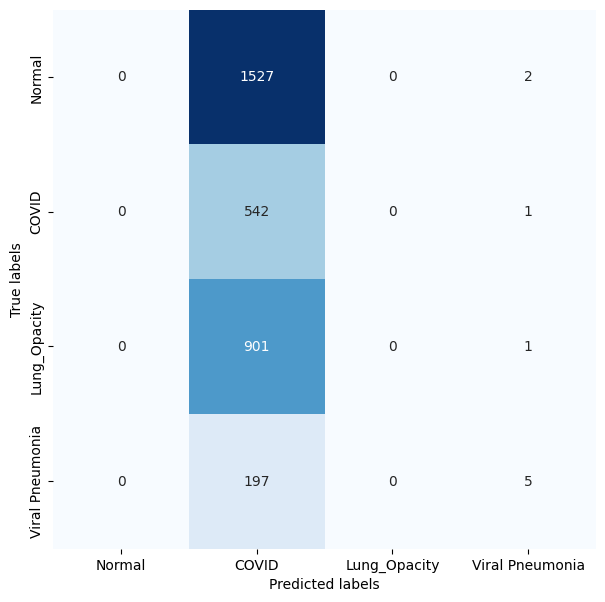

In [35]:
# show and save confusion matrix with absolute values:
create_cm(y_true, y_pred, None , model_results_path, model_name)

norma
true


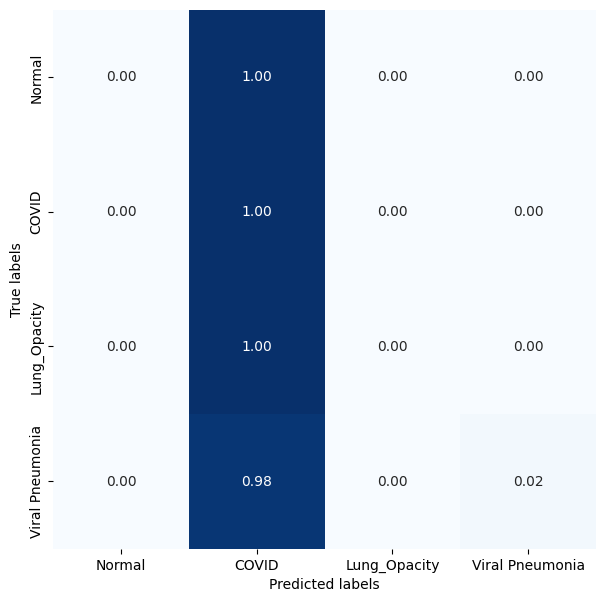

In [36]:
# show and saveonfusion matrix with normalized values:
create_cm(y_true, y_pred, 'true' , model_results_path, model_name)

### not used code for evaluation

In [37]:
# # Display the confusion matrix
# plt.figure(figsize=(8, 8))  # Create a large figure for the confusion matrix
# cnf_matrix = confusion_matrix(y_true, y_pred, normalize='true')  # Compute the normalized confusion matrix

# sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False, fmt=".2f", xticklabels=classes, yticklabels=classes)  # Plot the confusion matrix as a heatmap
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.show()

In [38]:
# def get_predictions_and_labels(dataset):
#     true_labels = []
#     pred_labels = []

#     for images, labels in dataset:

#         preds = model.predict(images, verbose=0)  # Get the model's predictions
#         pred_labels.extend(np.argmax(preds, axis=-1))  # Get the predicted labels (argmax)
#         #pred_labels.extend(preds)  # Get the predicted labels (argmax)

#         true_labels.extend(labels.numpy())  # Get the true labels

#     return np.array(true_labels), np.array(pred_labels)

# y_true, y_pred = get_predictions_and_labels(test_ds)  # Get true labels and predictions from the test dataset


In [39]:
#print(classification_report(y_true, y_pred, target_names=classes))

In [40]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt


# cm_abs_file = os.path.join(model_results_path, model_name + '_loss_accuracy.png')

# # Compute confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Plot confusion matrix with class names
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# plt.figure(figsize=(8,8))
# disp.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix")
# plt.show()